# **Module 4: Diagnostic Systems**
## DAT410

### Group 29 
### David Laessker, 980511-5012, laessker@chalmers.se

### Oskar Palmgren, 010529-4714, oskarpal@chalmers.se



We hereby declare that we have both actively participated in solving every exercise. All solutions are entirely our own work, without having taken part of other solutions.

___


## 1) Article summary and take-aways

The first paper by Wolberg et al. (1994) focuses on development of an interactive computer system that diagnoses breast cancer from FNA slides (fine needle aspirate). By utilising image analysis and machine learning, their system demonstrated high accuracy, which highlighted the potential of combining ML with digital image to enhance accuracy of breast FNAs diagnoses. We thought it was interesting that computer-assisted image analysis was superior to eyepiece measurements with respect to accuracy and reproducability of the results achieved in the breast cancer study.

*The Mythos of Model Interpretability* (2018) discusses the concept of interpretability in machine learning models and its complexity. Transparency in the model decisions and post-hoc interpretations of model outputs are suggested as the main approaches. Models should either be understandable by design or provided with clear explanations of the results in order to achieve trust and fairness. In particular we found the discussion on the tradoffs between linear models and neural networks was interesting and relevant to the work we do, as choosing a model that fits the data is very important.

Our main takeaways from both research papers are the potential and challenges of applying machine learning to areas such as medical diagnostics. Significantly improving the accuracy of a diagnosis with ML is promising, however, we need to ensure that the models used are transparent and easily interpretable for this kind of complicated decision making. There are many factors that come into play when choosing a model that fits the data, and we should be aware of the tradoffs in different aspects when approaching these desicions.


___
## 2) Implementation

### 2.1) Rule-based classifier

For the rule-based classifier, we try two different approaches: 

*(a)*. Based on the supplied data, assuming that we know which cells are malignant/benign from the label column and using the respective data to determine what is abnormal.

*(b)*. Based on the supplied data, but we dont know the labels of each cell. We use the data to calculate an averages and standard deviations to define ourselves what is abnormal.

In [102]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix

In [103]:
# Load dataset as a df
data = pd.read_pickle('wdbc.pkl')

# Show the first few rows
data.head()

,id,malignant,radius_0,texture_0,perimeter_0,area_0,smoothness_0,compactness_0,concavity_0,concave points_0,...,radius_2,texture_2,perimeter_2,area_2,smoothness_2,compactness_2,concavity_2,concave points_2,symmetry_2,fractal dimension_2
0,842302,1,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,842517,1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,84300903,1,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,84348301,1,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,84358402,1,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


### Rule approach a)

For our first approach we create a class called Rule_Classifier. This class attempts to find a few features that have big differences in the malignant an non malignant data. A big difference is defined as the average of the respective means have a difference that is larger than their respective standard deviations added. We then use only these features to classify the diagnosis. If an image has more features that are closer to the malignant means than the non-maligant means it is classified as maligant, and if not, then it is classified as non-maligant. On this approach we are using all of the data as a point for training, as we are using no tuning or cross validation in this approach. It is simply basically mathematical. So if a new image is to be classified, it is only using these big difference points and is trained on all of the previous data. With this approach we achieve an accuracy of 0.907. We decided to remove the unimportant features, as these were difficult to make rules for, and we decided to focus on maing rules for the features who had big differences in mean values, as these give us a likely better prediction based of simple rules. 

In [104]:
class Rule_Classifier:
    def __init__(self, dataframe):
        self.data = dataframe.copy()
        self.big_differences = {}
        self.non_maligant = self.data[self.data['malignant'] == 0].drop('malignant', axis=1)
        self.maligant = self.data[self.data['malignant'] == 1].drop('malignant', axis=1)
        for column in self.data.drop('malignant', axis=1).columns:
            mal_mean = self.maligant[column].mean()
            non_mean = self.non_maligant[column].mean()
            mal_std = self.maligant[column].std()
            non_std = self.non_maligant[column].std()
            if abs(mal_mean - non_mean) > (mal_std + non_std):
                self.big_differences[column] = (non_mean, mal_mean)

    def predict(self, data):
        data['manual_classification'] = 0
        for index, row in data.iterrows():
            non_count = 0
            mal_count = 0
            for column in self.big_differences:
                if abs(row[column] - self.big_differences[column][0]) < abs(row[column] - self.big_differences[column][1]):
                    non_count += 1
                else:
                    mal_count += 1
            if non_count > mal_count: # Tweakable parameter ;)
                data.at[index, 'manual_classification'] = 0
            else:
                data.at[index, 'manual_classification'] = 1
        return data['manual_classification']
    
    def score(self, data):
        correct = 0
        for index, row in data.iterrows():
            if row['manual_classification'] == row['malignant']:
                correct += 1
        accuracy = correct / len(data)
        return accuracy

In [106]:
RB_data = data.copy()

# Create the rule based classifier
rule_classifier = Rule_Classifier(RB_data)

# Predict the class of the data
RB_data['manual_classification'] = rule_classifier.predict(RB_data)

# Calculate the accuracy of the classifier
accuracy = rule_classifier.score(RB_data)
print(f'Accuracy: {accuracy:.3f}')

#matrix = confusion_matrix(data['malignant'], prediction)      
#sns.heatmap(matrix, annot=True, fmt="d", cmap="Blues")

Accuracy: 0.907


### 2.1 b)

A different approach where we do not know the actual labels, only use the features to predict. We calculate the average $\mu$ and standard deviation $\sigma$, and define abnormal as $\mu \pm k\sigma$. We set $k=2$, which statistically encompasses about $95 \%$ of the data and results in the data in the $2.5$-th and $97.5$-th percentiles being considered abnormal. Here we assume that the given data is normally distributed, which is not really the case for some features when looking at the histogram plots below. 

In [107]:
benign = data[data['malignant'] == 0]
malignant = data[data['malignant'] == 1]

features = ['radius_0', 'perimeter_0', 'area_0', 'concavity_0', 'concave points_0', 'compactness_0', 'texture_0', 'smoothness_0', 'symmetry_0']

data_stats = data[features].agg(['mean', 'std'])

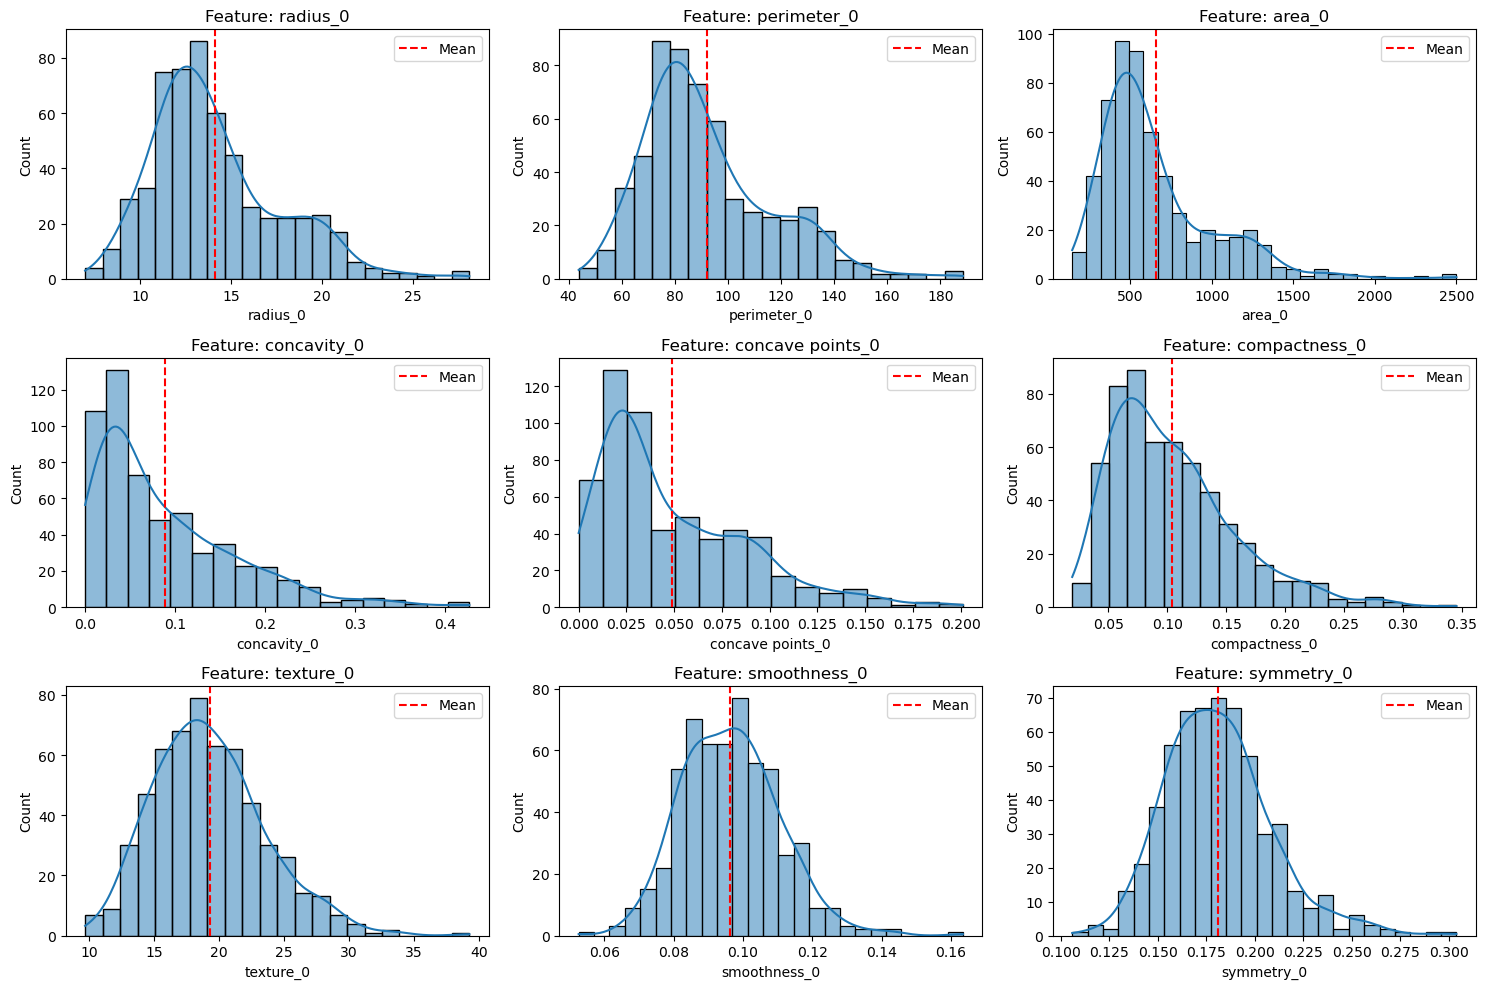

In [108]:
plt.figure(figsize=(15, 10))

for i, feature in enumerate(features, 1):
    plt.subplot(3, 3, i)
    sns.histplot(data[feature], kde=True)
    plt.axvline(data_stats[feature].loc['mean'], color='r', linestyle='dashed', label='Mean')
    plt.legend(loc='upper right')
    plt.title(f'Feature: {feature}')


plt.tight_layout()
plt.show()



In [109]:
def RB_classifier2(row, stats, features):
    '''
    Rule based classifier, goes through all the rows of data feature by feature. 
    If the value is larger than the mean + 2 std or smaller than mean - 2std, 
    then the row is classified as malignant. Otherwise benign
    '''

    for feature in features:
        
        mean = stats[feature]['mean']
        std = stats[feature]['std']
        
        if row[feature] > mean + 2*std or row[feature] < mean - 2*std: 
            return 1
    
    return 0



prediction =  data.copy().apply(RB_classifier2, axis=1, args=(data_stats, features,))


accuracy_score(data['malignant'], prediction)


0.6766256590509666

We get an accuracy of 67.7%, which is not great. Some possible factors in order to improve the score would be to take into account that the data is not normally distributed, and shift the thresholds for

### 2.2) Random Forest Classifier

Here we are using the random forest classifier to classify the data instead. We achieve an accuracy of 0.965

In [110]:
data_features = data.drop(columns=['id', 'malignant'])
data_labels = data['malignant']

X_train, X_test, y_train, y_test = train_test_split(data_features, data_labels, test_size=0.2, random_state=0)

RF_classifier = RandomForestClassifier(n_estimators=100, random_state=0)
RF_classifier.fit(X_train, y_train)
y_pred = RF_classifier.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)

print(accuracy)

0.9649122807017544


### 2.3) Own Classifier

For our own classifier we decided to implement feature boosting. We create a class for this called Boosting_Classifier, after testing and plotting we got the best performance at about 500 estimators and upwards, using a max_depth of 1. We achieve a significant improvement on the random forest classifier.

In [111]:
# -------------------- Feature boosting --------------------
# We crate a classifier class using the GradientBoostingClassifier from sklearn
# We use the init, predict and score methods to create a classifier class

from sklearn.ensemble import GradientBoostingClassifier

class Boosting_Classifier:
    def __init__(self, dataframe):
        self.data = dataframe
        self.features = self.data.drop(columns=['id', 'malignant'])
        self.labels = self.data['malignant']
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(self.features, self.labels, test_size=0.2, random_state=0)
        self.clf = GradientBoostingClassifier(n_estimators=500, learning_rate=0.1, max_depth=1, random_state=0)
        self.clf.fit(self.X_train, self.y_train)
        self.y_pred = self.clf.predict(self.X_test)
        self.accuracy = accuracy_score(self.y_test, self.y_pred)
        
    def predict(self, data):
        return self.clf.predict(data)
    
    def score(self, data):
        return self.accuracy

GB_data = data.copy()
# Create the boosting classifier
boosting_classifier = Boosting_Classifier(GB_data)

# Predict the class of the data
GB_data['manual_classification'] = boosting_classifier.predict(GB_data.drop(columns=['id', 'malignant']))

# Calculate the accuracy of the classifier
accuracy = boosting_classifier.score(GB_data)
print(f'Accuracy: {accuracy:.5f}')

Accuracy: 0.98246


In [112]:
# Use decision tree classifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

# Create the classifier
clf = DecisionTreeClassifier(random_state=0, max_depth=3)

# Train the classifier
clf.fit(X_train, y_train)

# Make predictions
y_pred = clf.predict(X_test)

# Calculate the accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.3f}')

Accuracy: 0.965


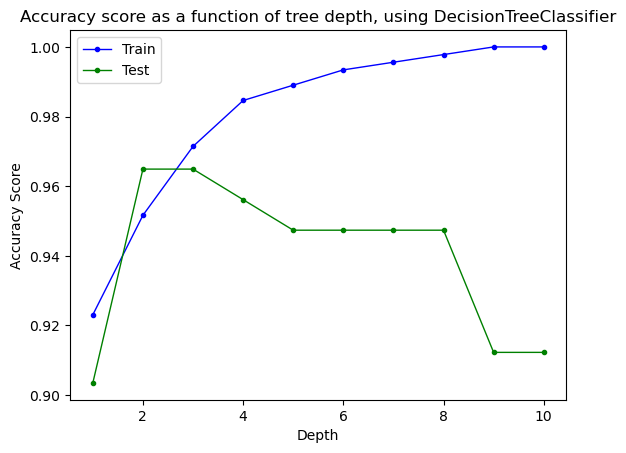

In [11]:
depths = range(1, 11)
acc_train = []
acc_test = []

for i in depths:
    DC = DecisionTreeClassifier(max_depth = i)
    DC.fit(X_train, y_train)

    # calculate the accuracy scores
    Yguess_train = DC.predict(X_train)
    acc_train.append(accuracy_score(y_train, Yguess_train))
    
    Yguess_test = DC.predict(X_test)
    acc_test.append(accuracy_score(y_test, Yguess_test))


import matplotlib.pyplot as plt
plt.plot(depths, acc_train, 'o-', lw=1, markersize=3, color='blue', label='Train')
plt.plot(depths, acc_test, 'o-', lw=1, markersize=3, color='green', label='Test')

plt.title("Accuracy score as a function of tree depth, using DecisionTreeClassifier")
plt.ylabel("Accuracy Score")
plt.xlabel("Depth")
plt.legend()
plt.show()

KeyboardInterrupt: 

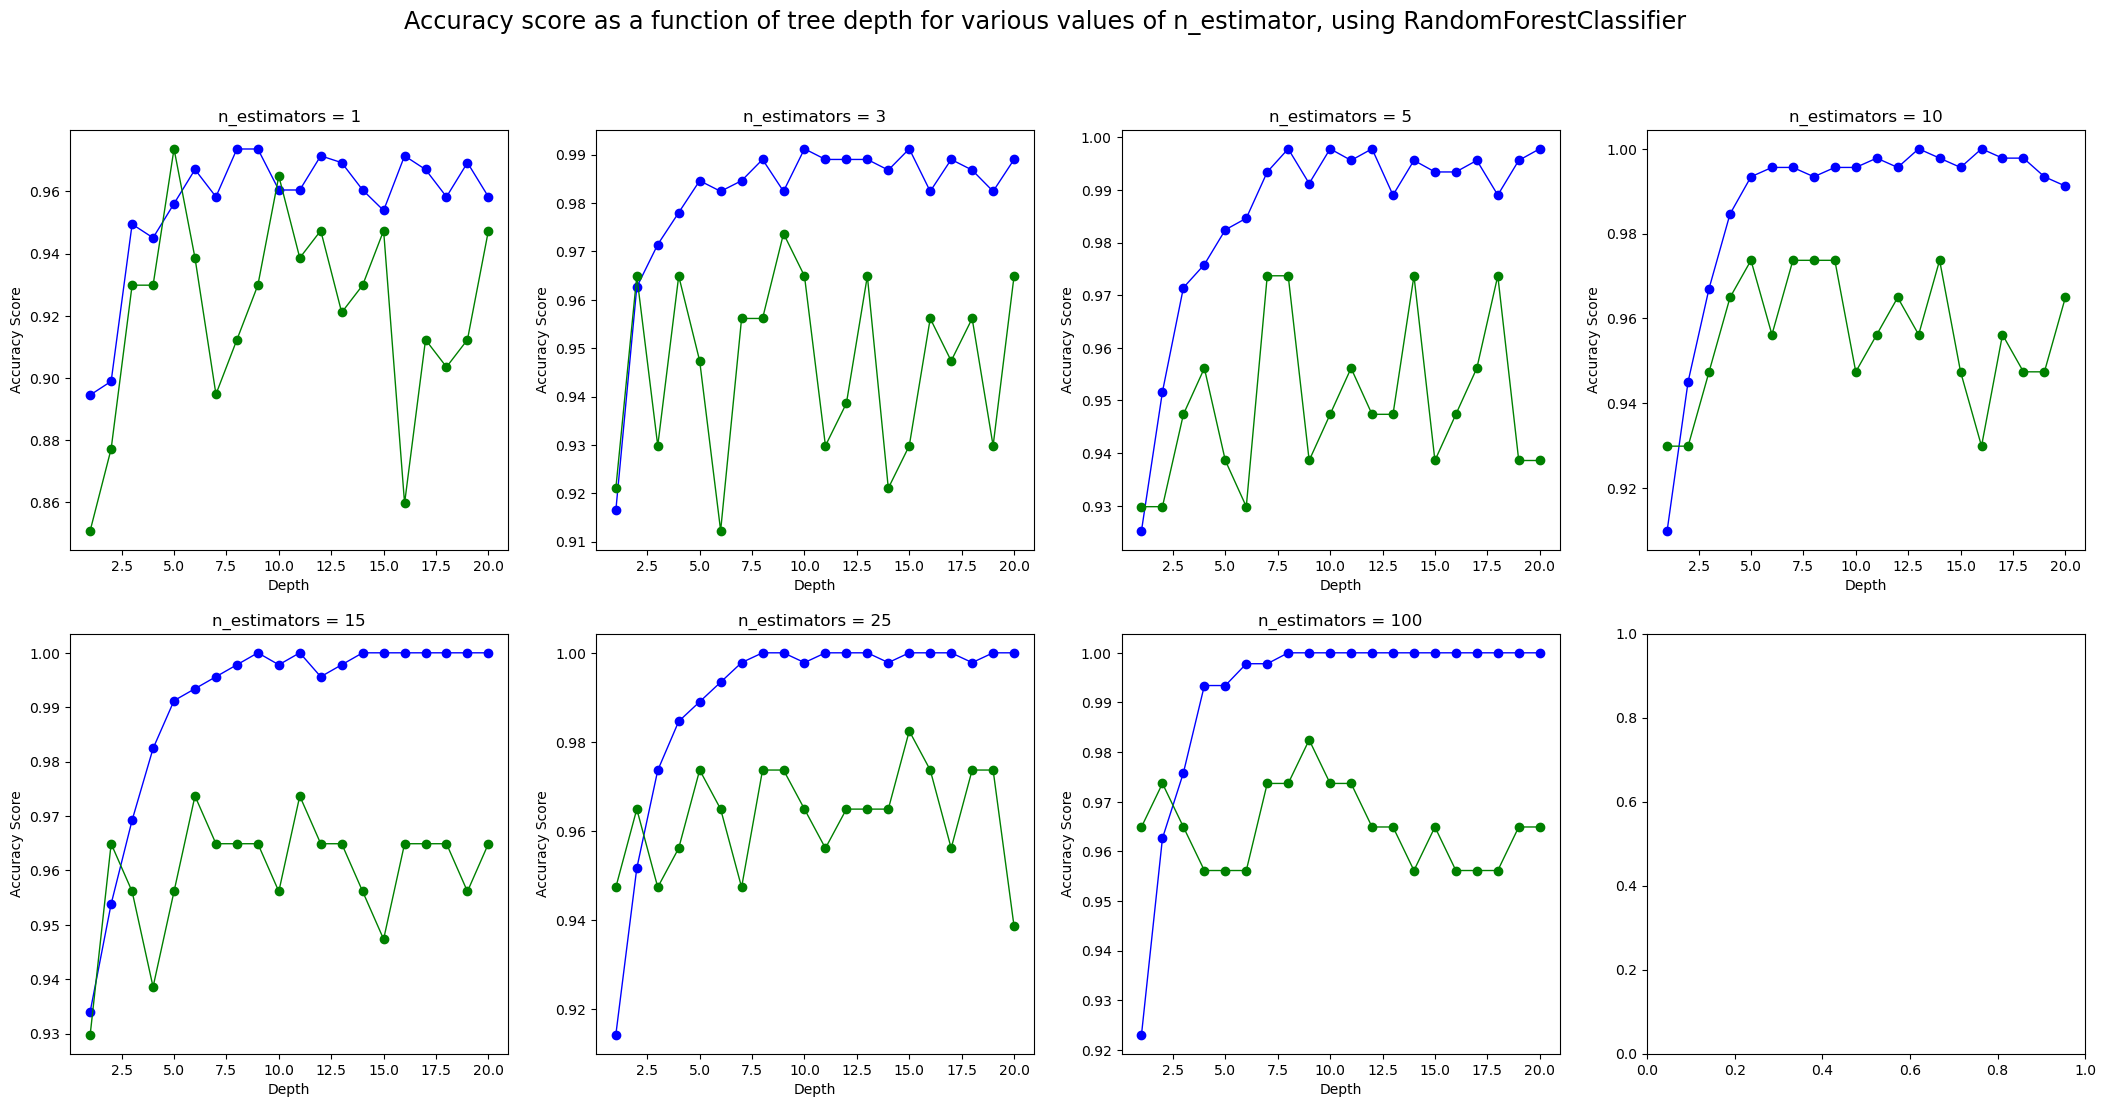

In [12]:
def RForest(Xtr, Xte, Ytr, Yte, max_d, n_est, n_j=None):
    
    acc_tr = [] #accuracies for training data
    acc_te = [] #accuracies for test data

    for i in max_d:
        RF = RandomForestClassifier(n_estimators=n_est, max_depth=i, n_jobs=n_j)
        RF.fit(Xtr, Ytr)
        
        Yguess_tr = RF.predict(Xtr)
        acc_tr.append(accuracy_score(Ytr, Yguess_tr))
        
        Yguess_te= RF.predict(Xte)
        acc_te.append(accuracy_score(Yte, Yguess_te))

    return acc_tr, acc_te

depths = range(1,21)

n_est = [1, 3, 5, 10, 15, 25, 100, 350]

fig, axs = plt.subplots(2, 4, figsize=(26, 12))

fig.suptitle('Accuracy score as a function of tree depth for various values of n_estimator, using RandomForestClassifier', size='xx-large')

k=0
n_j=None

for i in range(2):
    for j in range(4):
        
        if i == 1:
            k = 4
            n_j = -1

        data = RForest(X_train, X_test, y_train, y_test, depths, n_est[j+k], n_j)

        axs[i, j].plot(depths, data[0], 'o-', lw=1, color='blue', label='Train')
        axs[i, j].plot(depths, data[1], 'o-', lw=1, color='green', label='Test')

        axs[i, j].set_title('n_estimators = {}'.format(n_est[j+k]))

        axs[i, j].set_ylabel("Accuracy Score")
        axs[i, j].set_xlabel("Depth")

handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
fig.legend(by_label.values(), by_label.keys(), loc = "center left")




In [122]:
#Most important features

RFC = RandomForestClassifier(n_estimators = 100)
RFC.fit(X_train, y_train)


# access feature names and importance scores
feature_names = data_features.columns
importances = RFC.feature_importances_.tolist()


# associate importance scores with feature names and sort in descending order
result = {feature_names[i]: importances[i] for i in range(len(feature_names))}
result_sorted = sorted(result.items(), key=lambda x:x[1], reverse=True)

for res in result_sorted:
    print(res)

('perimeter_2', 0.13776514817402644)
('radius_2', 0.12686437964008238)
('concave points_2', 0.1133228484617879)
('area_2', 0.10582842745806523)
('concave points_0', 0.08361446534058709)
('concavity_0', 0.061161583688145664)
('area_0', 0.05604726437421112)
('radius_0', 0.04984797983070357)
('concavity_2', 0.038179055654724216)
('perimeter_0', 0.0372295837581353)
('area_1', 0.02664848306532021)
('texture_2', 0.016681661693087997)
('texture_0', 0.0164112278025905)
('compactness_2', 0.013252564907291856)
('compactness_0', 0.012170213234122493)
('symmetry_2', 0.012110050124625748)
('radius_1', 0.011945431948291165)
('smoothness_2', 0.011174052651445257)
('perimeter_1', 0.010780524408395024)
('smoothness_0', 0.00867014216076962)
('fractal dimension_2', 0.008351537249366802)
('compactness_1', 0.005978319441240852)
('concavity_1', 0.00549645826627322)
('texture_1', 0.0054577030922675724)
('symmetry_0', 0.005173442437935693)
('fractal dimension_1', 0.004568143087474962)
('symmetry_1', 0.0043491

Hyperparameter tuning

In [119]:
from sklearn.model_selection import RandomizedSearchCV

parameter_space = {
    'min_samples_leaf': [x for x in range(1, 11)],
    'min_samples_split': [x for x in range(2, 20)],
    'n_estimators': [x for x in range(100, 1000, 100)],
    'learning_rate': [x for x in np.arange(0, 0.2, 0.01)],
    'max_depth': [x for x in range(1, 11)],
    'subsample': [x for x in np.arange(0.5, 1, 0.1)],
    'max_leaf_nodes': [None, 10, 20, 30, 40, 50]
    }

GBC = GradientBoostingClassifier(random_state=0)

test_search = RandomizedSearchCV(GBC, parameter_space, n_jobs=-1, cv=3)
test_search.fit(X_train, y_train)

print('Best parameters:', test_search.best_params_)
print('Best score:', test_search.best_score_)


Best parameters: {'subsample': 0.6, 'n_estimators': 400, 'min_samples_split': 10, 'min_samples_leaf': 10, 'max_leaf_nodes': 10, 'max_depth': 2, 'learning_rate': 0.05}
Best score: 0.9670762170326479


In [121]:
GBC_test = GradientBoostingClassifier(n_estimators=400, subsample=0.6, min_samples_split=10, min_samples_leaf=10, max_leaf_nodes= 10, max_depth=2, learning_rate= 0.05, random_state=0)

GBC_test.fit(X_train, y_train)

y_pred = GBC_test.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)

print(accuracy)




0.9824561403508771


___
## 3) Disucussion